In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import keras_lmu

In [2]:
sequentialMNIST = pickle.load(open('Data/sequentialMNIST.pickle', 'rb'))
permutedMNIST = pickle.load(open('Data/permutedMNIST.pickle', 'rb'))

train_sequential_X = sequentialMNIST['train']['images']
train_sequential_y = sequentialMNIST['train']['labels']
train_permuted_X = permutedMNIST['train']['images']
train_permuted_y = permutedMNIST['train']['labels']

In [3]:
# Stratified 80-20 split into train and validation sets
from sklearn.model_selection import train_test_split

train_sequential_X, val_sequential_X, train_sequential_y, val_sequential_y = train_test_split(train_sequential_X, train_sequential_y, test_size=0.2, stratify=train_sequential_y, random_state=42)
train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y = train_test_split(train_permuted_X, train_permuted_y, test_size=0.2, stratify=train_permuted_y, random_state=42)

# Check Shapes
print('Sequential MNIST')
print('Train X Shape: ', train_sequential_X.shape)
print('Train y Shape: ', train_sequential_y.shape)
print('Validation X Shape: ', val_sequential_X.shape)
print('Validation y Shape: ', val_sequential_y.shape)

print('Permuted MNIST')
print('Train X Shape: ', train_permuted_X.shape)
print('Train y Shape: ', train_permuted_y.shape)
print('Validation X Shape: ', val_permuted_X.shape)
print('Validation y Shape: ', val_permuted_y.shape)

Sequential MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)
Permuted MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)


In [4]:
# loop and check labels are same for each split

for i in range(len(train_sequential_y)):
    assert np.array_equal(train_sequential_y[i], train_permuted_y[i])

for i in range(len(val_sequential_y)):
    assert np.array_equal(val_sequential_y[i], val_permuted_y[i])

### 1. Visualize 3 Random Images

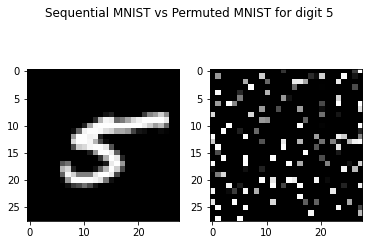

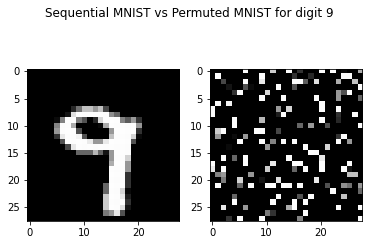

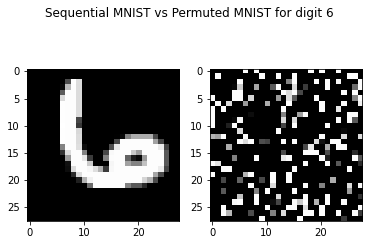

In [5]:
for i in range(3):
    # Set Seed
    np.random.seed(i)
    # Choose a random image
    random_index = np.random.randint(0, len(train_sequential_X))
    # Plot the image at the random index from both datasets
    plt.subplot(1, 2, 1)
    plt.imshow(train_sequential_X[random_index].reshape(28,28), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(train_permuted_X[random_index].reshape(28,28), cmap='gray')
    plt.suptitle('Sequential MNIST vs Permuted MNIST for digit {}'.format(train_sequential_y[random_index]))
    plt.show()

### 2. RNN Based Architecture

In [6]:
n_pixels = train_sequential_X.shape[1]

lmu_layer = tf.keras.layers.RNN(
    keras_lmu.LMUCell(
        memory_d=1,
        order=256,
        theta=n_pixels,
        hidden_cell=tf.keras.layers.SimpleRNNCell(212),
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        kernel_initializer="ones",
    )
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784, 1)]          0         
                                                                 
 rnn (RNN)                   (None, 212)               99641     
                                                                 
 dense (Dense)               (None, 10)                2130      
                                                                 
Total params: 101,771
Trainable params: 101,771
Non-trainable params: 0
_________________________________________________________________


In [7]:
do_training = True
batch_size = 100
epochs = 20

saved_weights_fname = "Saves/psMNIST-weights.hdf5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_weights_fname, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

if do_training:
    result = model.fit(
        train_sequential_X,
        train_sequential_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_sequential_X, val_sequential_y),
        callbacks=callbacks,
    )

Epoch 1/20


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  6/480 [..............................] - ETA: 1:42:20 - loss: 2.6335 - accuracy: 0.1717

In [ ]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Post-epoch Training Accuracies")
    plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
    plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
    plt.savefig("Saves/psMNIST-training.png")

    val_loss_min = np.argmin(result.history["val_loss"])
    print(
        f"Maximum validation accuracy: "
        f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
    )

else:
    display(Image(filename="/content/drive/MyDrive/LMU_DL_A3_Q1/psMNIST-training.png"))